# Driver Drowsiness Detection System

 A countless number of people drive on the highway day and night. Taxi drivers, bus drivers, truck drivers and people traveling long-distance suffer from lack of sleep. Due to which it becomes very dangerous to drive when feeling sleepy.

The majority of accidents happen due to the drowsiness of the driver. So, to prevent these accidents we will build a system using Python, tensorflow, and Keras which will alert the driver when he feels sleepy.

**Architecture** : VGG16

### **Imports**

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import random
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Check for GPU availability
if tf.test.is_gpu_available():
    print("GPU is available!")
else:
    print("GPU is NOT available!")

# Check for TPU availability
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)  # Use tf.distribute.TPUStrategy instead of experimental
    print("TPU is available!")
except ValueError:
    print("TPU is NOT available!")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available!
TPU is NOT available!


## **Google Drive**

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

base_path_train = "drive/MyDrive/Dataset_dl_project/train"
base_path_validation = "drive/MyDrive/Dataset_dl_project/validation"
base_path_test = "drive/MyDrive/Dataset_dl_project/test"
Classes = ['close eyes', 'open eyes']
num_classes = len(Classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Utility Functions**

### **Title**: Code Explanation - VGG16 Model Training

 **Function to Create Training Data**

*   The create_training_Data function prepares the training data for the model.
*   It reads and preprocesses the images, converts them to RGB, and resizes them.
*   Each image is paired with its corresponding label and added to the training_Data list.
*   The function returns the prepared training_Data.

 **Preparing the Training Data**

*   The create_training_Data function prepares the training data by reading, resizing, and converting images to RGB.
*   Each image is paired with its corresponding label and added to the training_Data list.
*   The training data is shuffled randomly to ensure randomness during training.

**Model Architecture**

*   The VGG16 model is used as the base architecture for the model.
*   The top layer (fully connected layers) of VGG16 is excluded.
*   Four fully connected layers are added on top of the VGG16 base, with the final output layer using softmax activation for multiclass classification.

** Model Training**

*   The model is compiled with categorical cross-entropy loss, Adam optimizer, and evaluation metrics.
*   The training data is split into training and validation sets.
*   The model is trained for 2 epochs on the training set with a 10% validation split.

 **Model Evaluation**

*   The trained model is evaluated on the same training data to measure its performance.
*   Test loss, test accuracy, test precision, and test recall are computed and printed.

In [ ]:
img_size = 224
batch_size = 756

# Function to create training data
def create_training_data(base_path, classes, img_size, batch_size=32):
    all_files = []
    all_labels = []
    for i, category in enumerate(classes):
        path = os.path.join(base_path, category)
        files = tf.io.gfile.glob(os.path.join(path, '*.png'))
        all_files.extend(files)
        all_labels.extend([i] * len(files))

    all_files = tf.convert_to_tensor(all_files, dtype=tf.string)
    all_labels = tf.convert_to_tensor(all_labels, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((all_files, tf.keras.utils.to_categorical(all_labels, num_classes=num_classes)))

    def read_and_preprocess_image(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, (img_size, img_size))
        img = img / 255.0
        return img, label

    dataset = dataset.map(read_and_preprocess_image)

    # Shuffle and batch the dataset
    num_files = len(all_files)
    buffer_size = min(num_files, 1000)
    if buffer_size > 0:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)

    return dataset,num_files

def augment_data(image, label):
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random flip (horizontal and vertical)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random brightness and contrast adjustments
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)


    return image, label

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Learning rate scheduler
def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def create_model_1(base_model_name='vgg16', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

def create_model_2(base_model_name='vgg16', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

def create_model_3(base_model_name='vgg16', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

def create_model_4(base_model_name='vgg16', num_classes=1, fine_tune=False, dense_regularizer=None):
    if base_model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = fine_tune

    x = base_model.layers[-1].output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(16, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(8, activation='relu',kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(4, activation='relu', kernel_regularizer=dense_regularizer)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    return model

## **Load Dataset**

In [ ]:
start_time = time.time()
# Create the training dataset
train_dataset,num_files = create_training_data(base_path_train, Classes, img_size)
print("Total images :",num_files)
print("Total time Taken to load images :",time.time() - start_time)
start_time = time.time()
# Create the training dataset
validation_dataset,num_files = create_training_data(base_path_validation, Classes, img_size)
print("Total images :",num_files)
print("Total time Taken to load images :",time.time() - start_time)

Total images : 76032
Total time Taken to load images : 2.8347935676574707
Total images : 7089
Total time Taken to load images : 0.1085653305053711


## **Model Training**
**Architecture** : vgg16

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

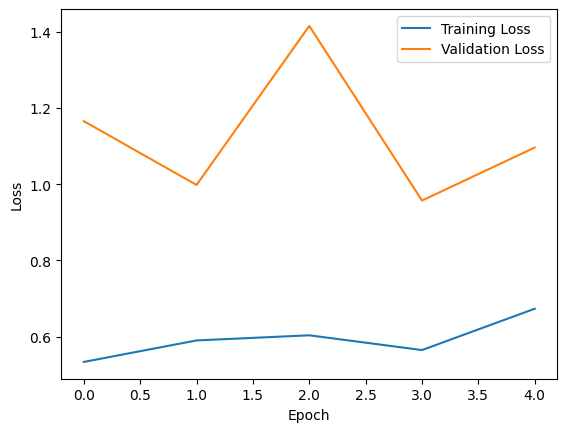

In [ ]:
# Create the model
base_model_name = 'vgg16'
regularizer = tf.keras.regularizers.l2(0.01)
model = create_model_1(base_model_name='vgg16', num_classes=2, fine_tune=False, dense_regularizer=regularizer)

model.layers[-1].units = num_classes
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training the model
history = model.fit(train_dataset, epochs=5, validation_data=validation_dataset)
# Save the trained model
model.save('vgg16_custom_model_1.h5')


#Validation plot
plot_loss(history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

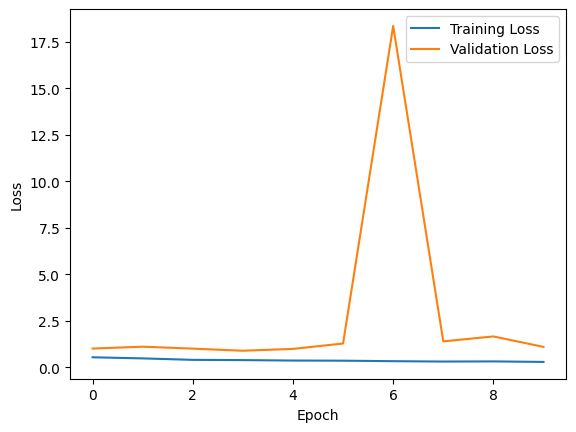

In [ ]:
# Create the model
base_model_name = 'vgg16'

model = create_model_3(base_model_name='vgg16', num_classes=2, fine_tune=False)

model.layers[-1].units = num_classes
model.summary()
train_dataset_augmented = train_dataset.map(augment_data)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training the model
history = model.fit(train_dataset_augmented, epochs=10, validation_data=validation_dataset)
# Save the trained model
model.save('vgg16_custom_model_3.h5')


#Validation plot
plot_loss(history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

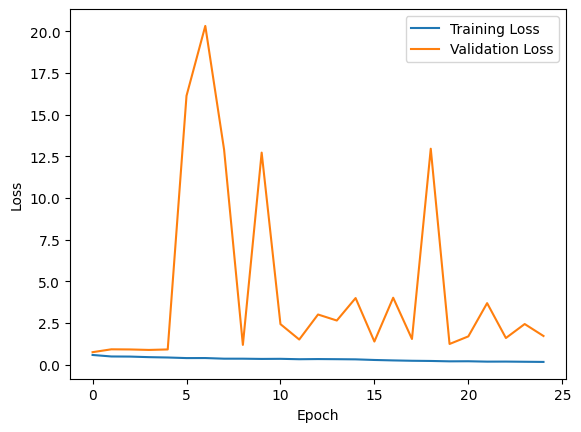

In [ ]:
# Create the model
base_model_name = 'vgg16'
# regularizer = tf.keras.regularizers.l2(0.01)
# model = create_model_4(base_model_name='vgg16', num_classes=2, fine_tune=False, dense_regularizer=regularizer)
model = create_model_4(base_model_name='vgg16', num_classes=2, fine_tune=False)
model.layers[-1].units = num_classes
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
train_dataset_augmented = train_dataset.map(augment_data)

# Training the model
history = model.fit(train_dataset_augmented, epochs=25, validation_data=validation_dataset, callbacks=[LearningRateScheduler(learning_rate_schedule)])

# Save the trained model
model.save('vgg16_custom_model_4.h5')


#Validation plot
plot_loss(history)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

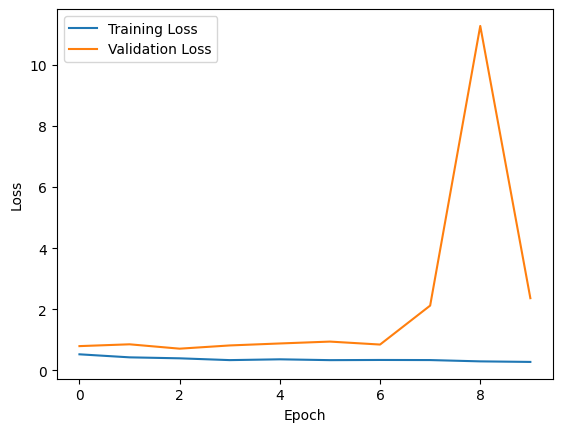

In [ ]:
# Create the model
base_model_name = 'vgg16'

model = create_model_3(base_model_name='vgg16', num_classes=2, fine_tune=False)

model.layers[-1].units = num_classes
model.summary()
# train_dataset_augmented = train_dataset.map(augment_data)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)
# Save the trained model
model.save('vgg16_custom_model_3.h5')


#Validation plot
plot_loss(history)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

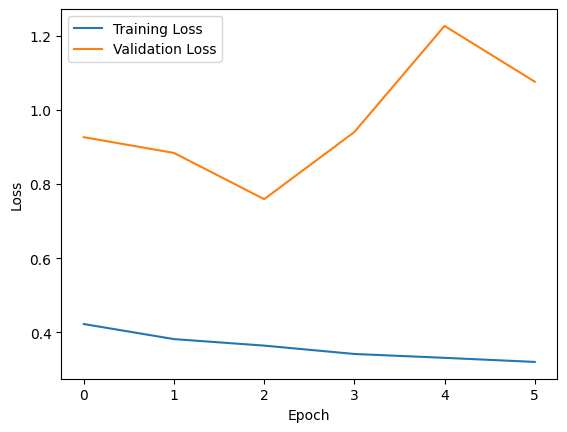

In [ ]:
# Create the model
base_model_name = 'vgg16'

model = create_model_3(base_model_name='vgg16', num_classes=2, fine_tune=False)

model.layers[-1].units = num_classes
model.summary()
# train_dataset_augmented = train_dataset.map(augment_data)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset,callbacks=[early_stopping])
# Save the trained model
model.save('vgg16_custom_model_3.h5')


#Validation plot
plot_loss(history)

In [ ]:
start_time = time.time()
# Create the training dataset
test_dataset,num_files = create_training_data(base_path_test, Classes, img_size)
print("Total images :",num_files)
print("Total time Taken to load images :",time.time() - start_time)

test_loss, test_accuracy, test_precision, test_recall =  model.evaluate(test_dataset)


Total images : 3223
Total time Taken to load images : 0.8605668544769287
101/101 [==============================] - 14s 124ms/step - loss: 0.3714 - accuracy: 0.9410 - precision_6: 0.9410 - recall_6: 0.9410


In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

### **Evaluation on test data**

Observations:

**Test Loss: 0.3714**


*   The test loss represents the discrepancy between the model's predicted values and the true labels for the test dataset. In this case, the test loss is relatively low, indicating that the model's predictions align reasonably well with the true labels.

**Test Accuracy:  0.9410**

*  The test accuracy measures the proportion of correctly classified samples in the test dataset.
*   Tthe test accuracy is approximately 94.10%, indicating that the model is correctly classifying a significant portion of the samples, but there is room for improvement.


**Test Precision: 0.9410**

*   Test precision measures the model's ability to correctly identify positive cases out of all predicted positive cases.
*   The precision score of approximately 94.10% suggests that the model is achieving moderate precision, correctly identifying positive cases without many false positives.


**Test Recall: 0.9410**

*   Test recall evaluates the model's ability to capture all positive cases out of all actual positive cases.
*    The recall score of approximately 94.10% indicates that the model is capturing a considerable portion of the positive cases, but there are still some positive cases that the model is missing.



Overall, the model demonstrates reasonable performance on the test dataset:

*   The relatively low test loss indicates that the model's predictions are somewhat aligned with the true labels, suggesting fair generalization to unseen data.
*   The test accuracy, precision, and recall scores show that the model is performing reasonably well, but there is potential for enhancement.
*   The precision score indicates that the model is making fewer false positive predictions, which is positive. However, the recall score suggests that the model is missing some positive samples, indicating the need to improve sensitivity. Further optimization and fine-tuning of the model may be required to improve its performance and achieve higher accuracy, precision, and recall. *   Additionally, domain-specific considerations and potential data augmentation strategies could be explored to enhance the model's generalization capabilities further.


## **Examples**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
def predict_single_image(model, image_path, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    #  predictions
    predictions = model.predict(img_array)

    predicted_class_index = np.argmax(predictions[0])
    predicted_probability = np.max(predictions[0])
    predicted_class_label = class_labels[predicted_class_index]
    probability_text = f"Probability: {predicted_probability:.2f}"

    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class_label}, {probability_text}")

    plt.axis('off')
    plt.show()

    return predicted_class_label

1/1 [==============================] - 0s 26ms/step


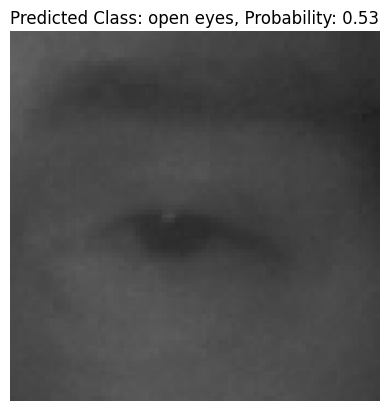

'open eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'open eyes','s0001_01844_0_0_1_0_0_01.png'), Classes)

1/1 [==============================] - 0s 350ms/step


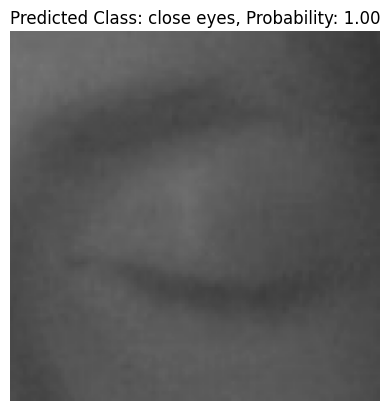

'close eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'close eyes','s0002_00001_0_0_0_0_0_01.png'), Classes)

1/1 [==============================] - 0s 196ms/step


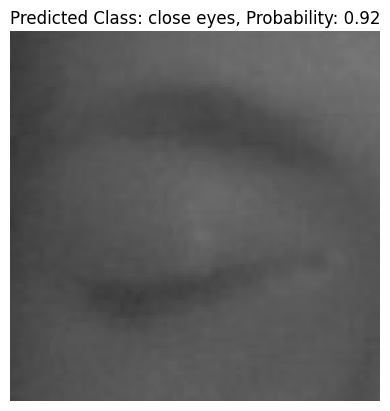

'close eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'close eyes','s0002_00691_0_0_0_0_0_01.png'), Classes)

1/1 [==============================] - 0s 32ms/step


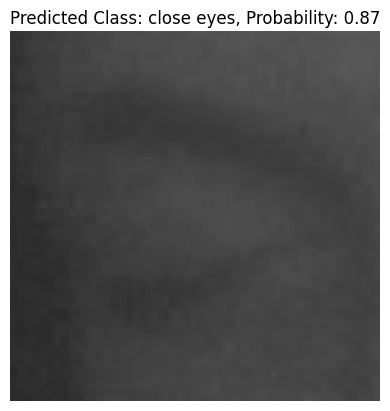

'close eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'close eyes','s0002_00947_0_0_0_0_0_01.png'), Classes)

1/1 [==============================] - 0s 31ms/step


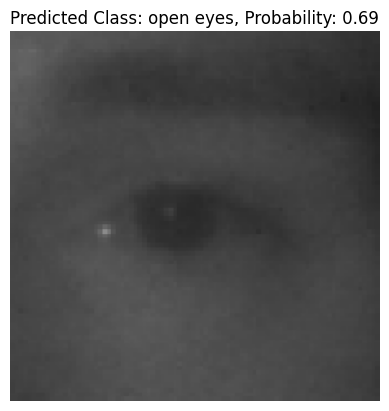

'open eyes'

In [ ]:

predict_single_image(model, os.path.join(base_path_test,'open eyes','s0001_01876_0_0_1_0_0_01.png'), Classes)

1/1 [==============================] - 0s 20ms/step


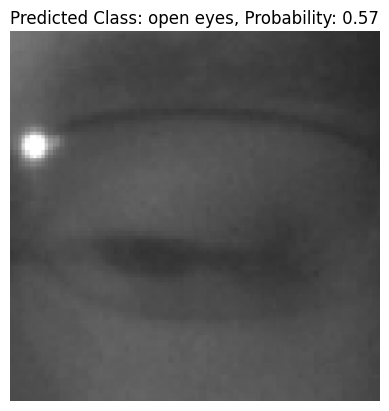

'open eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'open eyes','s0001_02902_0_1_1_1_0_01.png'), Classes)

1/1 [==============================] - 0s 160ms/step


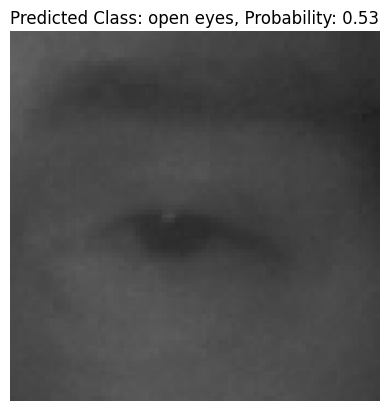

'open eyes'

In [ ]:
predict_single_image(model, os.path.join(base_path_test,'open eyes','s0001_01844_0_0_1_0_0_01.png'), Classes)

In [ ]:
mod